#### Import Library

In [4]:
# Data Analysis
import pandas as pd
import numpy as np
import csv
import nltk

import csv
import nltk
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# CRF
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

In [5]:
df = pd.read_csv("SINGGALANG.tsv", header = None, delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
print(df)

                0    1
0            Word  Tag
1              Ia    O
2        menjabat    O
3         sebagai    O
4        Presiden    O
...           ...  ...
1051908      pada    O
1051909   tanggal    O
1051910        20    O
1051911   Oktober    O
1051912      1945    O

[1051913 rows x 2 columns]


In [10]:
list_kalimat = []
nomor_kalimat = 1

with open('SINGGALANG.tsv', encoding='UTF-8') as read_obj:
    csv_reader = csv.reader(read_obj, delimiter='\t', quotechar=None)
    for row in csv_reader:
        if len(row) == 0:
            nomor_kalimat += 1 
        else:
            tmp_row= row
            tmp_row.append(nomor_kalimat)
            list_kalimat.append(tmp_row)

dataset = pd.DataFrame(list_kalimat, columns=['Word', 'Tag', 'kalimat'])

In [11]:
dataset.head(5)

,Word,Tag,kalimat
0,Ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,Presiden,O,1
4,ketiga,O,1


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051912 entries, 0 to 1051911
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   Word     1051912 non-null  object
 1   Tag      1051912 non-null  object
 2   kalimat  1051912 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.1+ MB


#### Exploring Data

In [15]:
class getSentence(object): 
    
    def __init__(self, data):
      self.n_sent = 1.0
      self.dataset = dataset
      self.empty = False 
       
      agg_func = lambda s: [(t, e) for t, e in zip(s["Word"].values.tolist(),
                                                 s["Tag"].values.tolist())]                                           
      self.grouped = self.dataset.groupby("kalimat").apply(agg_func)
      self.sentences = [s for s in self.grouped]

In [17]:
getter = getSentence(dataset)
kalimat = getter.sentences
print(kalimat[1])

[('Robert', 'O'), ('Peter', 'O'), ('Maximillian', 'O'), ('Williams', 'Person'), ('-LRB-', 'O'), ('-RRB-', 'O'), ('merupakan', 'O'), ('penyanyi', 'O'), ('berkebangsaan', 'O'), ('Inggris.Dia', 'O'), ('adalah', 'O'), ('anggota', 'O'), ('kelompok', 'O'), ('pop', 'O'), ('Take', 'O'), ('That', 'O'), ('.', 'O')]


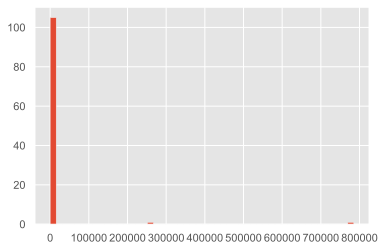

In [19]:
plt.style.use("ggplot")
plt.hist([len(s) for s in kalimat], bins=50)
plt.show()

In [20]:
maxlen = max([len(s) for s in kalimat])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 785361


In [23]:
dataset.loc[dataset['Tag'] == 'Person', 'Word'].head()

40     Sadat
105    Anwar
106    Sadat
110    Hafez
112    Assad
Name: Word, dtype: object

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


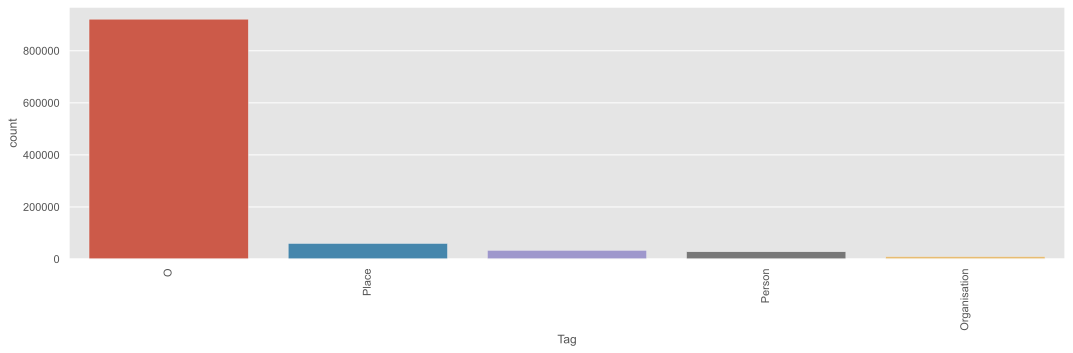

In [25]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


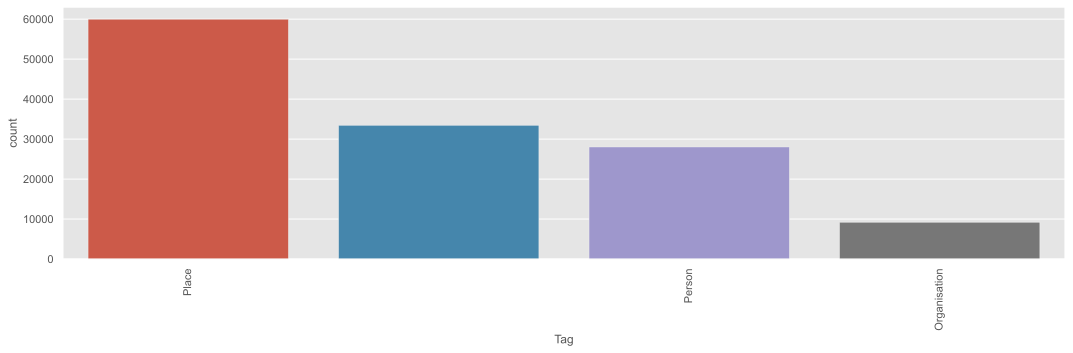

In [27]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=dataset.loc[dataset['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

#### Preprocessing

In [37]:
dataset_prep = pd.DataFrame(list_kalimat, columns=['Word', 'Tag', 'kalimat'])

In [41]:
import re
def perbaikan_format_tanda_baca(dataset_prep):    
    for i in dataset_prep.index:
        token = re.sub('([.,!?()])', r'\1 ', dataset_prep.at[i, 'Word'])
        dataset_prep.at[i, 'Word'] = re.sub('\s{2,}', ' ', token)
    return dataset_prep
perbaikan_format_tanda_baca(dataset_prep)

,Word,Tag,kalimat
0,Ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,Presiden,O,1
4,ketiga,O,1
...,...,...,...
1051907,terutama,O,107
1051908,pada,O,107
1051909,tanggal,O,107
1051910,20,O,107


In [42]:
# Lowercase
dataset_prep["Word"] = dataset_prep["Word"].str.lower()
dataset_prep.head()

,Word,Tag,kalimat
0,ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,presiden,O,1
4,ketiga,O,1


In [43]:
# BIO Annotation

bio_tag = []
prev_tag = "O"
for tag in dataset_prep['Tag']:
        if tag == "O": #O
            bio_tag.append((tag))
            prev_tag = tag
            continue
        if tag != "O" and prev_tag == "O": # Begin NE
            bio_tag.append(("B-"+tag))
            prev_tag = tag
        elif prev_tag != "O" and prev_tag == tag: # Inside NE
            bio_tag.append(("I-"+tag))
            prev_tag = tag
        elif prev_tag != "O" and prev_tag != tag: # NE yang berdekatan
            bio_tag.append(( "B-"+tag))
            prev_tag = tag

In [47]:
dataset_prep['bio_tag'] = bio_tag
dataset_prep.iloc[:2000]

,Word,Tag,kalimat,bio_tag
0,ia,O,1,O
1,menjabat,O,1,O
2,sebagai,O,1,O
3,presiden,O,1,O
4,ketiga,O,1,O
...,...,...,...,...
1995,kerajaan,Place,1,B-Place
1996,majapahit,Place,1,I-Place
1997,di,O,1,O
1998,bawah,O,1,O


In [53]:
master_count = dataset_prep["Tag"].value_counts() 
master_count

O                 921226
B-Place            45605
B-                 33448
B-Person           19311
I-Place            14389
I-Person            8717
B-Organisation      4614
I-Organisation      4597
I-                     5
Name: Tag, dtype: int64

In [65]:
dataset_prep.iloc[:2000]

,Word,Tag,kalimat
0,ia,O,1
1,menjabat,O,1
2,sebagai,O,1
3,presiden,O,1
4,ketiga,O,1
...,...,...,...
1995,kerajaan,B-Place,1
1996,majapahit,I-Place,1
1997,di,O,1
1998,bawah,O,1


#### Modeling Data

In [29]:
# Using Random Forest Classifier
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [31]:
words = [feature_map(w) for w in dataset["Word"].values.tolist()]
tags = dataset["Tag"].values.tolist()

In [32]:
print(words[:5])

[array([1, 0, 0, 2, 0, 1]), array([0, 1, 0, 8, 0, 1]), array([0, 1, 0, 7, 0, 1]), array([1, 0, 0, 8, 0, 1]), array([0, 1, 0, 6, 0, 1])]


In [33]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [34]:
# Evaluate Model from Random Forest

from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

                   1.00      1.00      1.00     33453
           O       0.92      0.99      0.95    921226
Organisation       0.00      0.00      0.00      9211
      Person       0.00      0.00      0.00     28028
       Place       0.47      0.19      0.27     59994

    accuracy                           0.91   1051912
   macro avg       0.48      0.44      0.44   1051912
weighted avg       0.86      0.91      0.88   1051912



c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install sklearn-crfsuite

In [66]:
# CRF Classifier
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

ModuleNotFoundError: No module named 'sklearn_crfsuite'